In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import metrics

#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.3.0
 GPU: /device:GPU:0


In [2]:
#set Image size (RGB so imshape is 3)
pix_dim = 416
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

In [3]:
#load model
filepath = './saved_VGG16_retrain_slower'
model = tf.keras.models.load_model(filepath, compile = True)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 416, 416, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 416, 416, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 416, 416, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 208, 208, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 208, 208, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 208, 208, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 104, 104, 128)    

In [4]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "flatten_2",
    "dense_4",
    "dropout_2",
    "dense_5",
]

In [5]:
#load Output
results_df = pd.read_csv('../data/VGG16_Michael_results.csv')
results_df


,Image,Observed,Predicted
0,P28462771.jpg,True,True
1,P28462380.jpg,True,True
2,P28463002.jpg,True,True
3,P28463062.jpg,True,True
4,P28463052.jpg,True,True
...,...,...,...
135,C28465015.jpg,False,False
136,S28468525.jpg,False,True
137,P28468886.jpg,False,False
138,S28468225.jpg,False,False


In [6]:
#FALSE POSITIVES
FP = results_df[(results_df['Observed'] == False) & (results_df['Predicted'] == True)]
#im name to list
FP_list = FP['Image'].tolist()
#remove jpg w/ list slicing
FP_list = [sub[ : -4] for sub in FP_list]

In [7]:
#FALSE Negative
FN = results_df[(results_df['Observed'] == True) & (results_df['Predicted'] == False)]
FN

,Image,Observed,Predicted
9,P28462451.jpg,True,False
18,P28462441.jpg,True,False
52,P28462501.jpg,True,False
57,P28462461.jpg,True,False
63,P28462491.jpg,True,False


In [8]:
#True Pos
TP = results_df[(results_df['Observed'] == True) & (results_df['Predicted'] == True)]
#im name to list
TP_list = TP['Image'].tolist()
#remove jpg w/ list slicing
TP_list = [sub[ : -4] for sub in TP_list]

In [9]:
#from https://keras.io/examples/vision/grad_cam/

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = imsize)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    #grads = tape.gradient(bottom_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

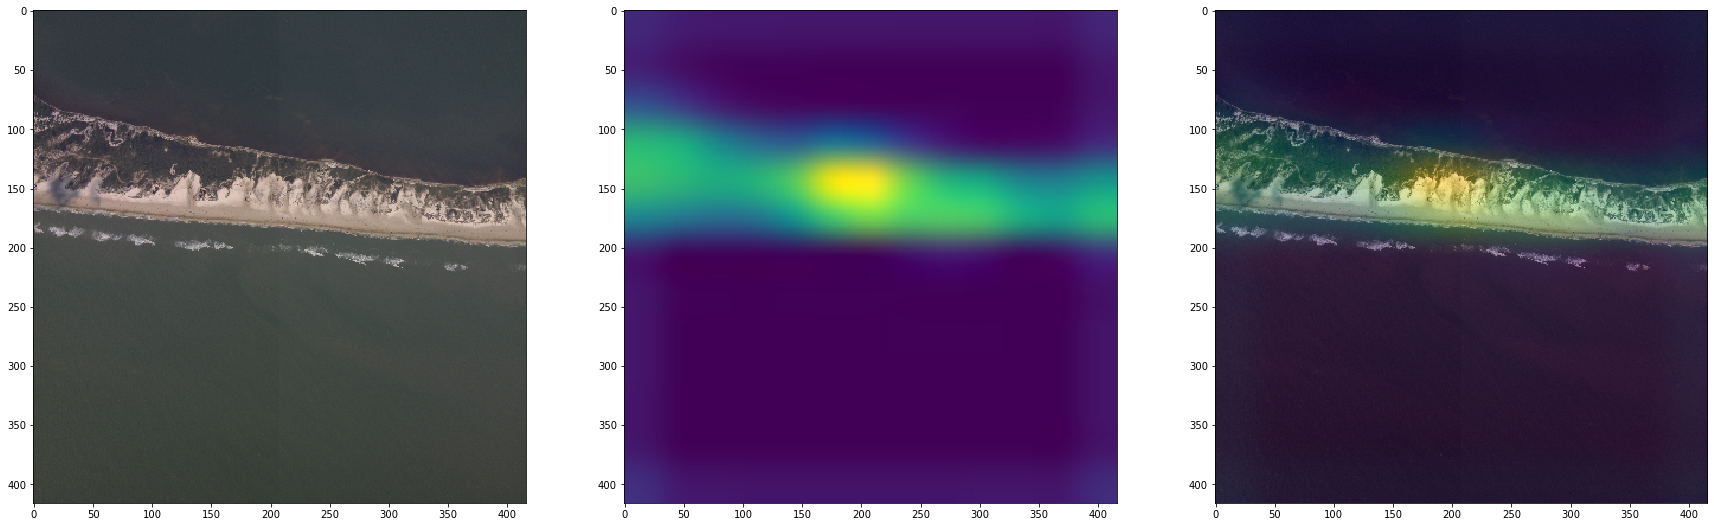

In [19]:
#from https://keras.io/examples/vision/grad_cam/
# Prepare image
ip = "P28463052"


impath = "../data/testing_michael/wash/" + str(ip) + ".jpg"
img = tf.keras.preprocessing.image.load_img(impath,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img_array = np.expand_dims(img,axis=0)


# Make the heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)
    
# get the original ERI image
Orimg = tf.keras.preprocessing.image.load_img(impath, target_size = imsize)
Orimg = tf.keras.preprocessing.image.img_to_array(Orimg)

# rescale image (range 0-255)
heatmap = np.uint8(255 * heatmap)

# use viridis for heatmap
vir = cm.get_cmap("viridis")
vir_colors = vir(np.arange(256))[:, :3]
vir_heatmap = vir_colors[heatmap]

# make the heatmap
vir_heatmap = tf.keras.preprocessing.image.array_to_img(vir_heatmap)
vir_heatmapI = vir_heatmap.resize((Orimg.shape[1], Orimg.shape[0]))
vir_heatmap = tf.keras.preprocessing.image.img_to_array(vir_heatmapI)

#put heatmpa on image
superimposed_img = vir_heatmap * 0.4 + Orimg
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Display Image, heatmap and overlay
# Display heatmap
plt.figure(figsize=(30,30))
plt.subplot(131)
plt.imshow(tf.keras.preprocessing.image.load_img(impath, target_size = imsize))
plt.subplot(132)
plt.imshow(vir_heatmapI)
plt.subplot(133)
plt.imshow(superimposed_img)
    
#save it
#plt.savefig('images/FPgrad_{}.pdf'.format(ip), format='pdf')